In [1]:
# set up main path where everything will be you should download the
# hugging face directory described in readme and put it here on the same
# server where the data analyzer is run so that the data analyzer code with 
# the GPU can access these files
# You should replace the below path with your location
import json
import os
try:
    with open('../config/config.json', 'r') as f:
        config = json.load(f)
    storage_path = config['storage_path']
    data_path = config['data_path']
    derivatives_path = config['derivatives_path']
    fsl_path = config['fsl_path']
    project_path = config['project_path']
    assert os.path.exists(storage_path), "The specified storage path does not exist."
    assert os.path.exists(data_path), "The specified data path does not exist."
    assert os.path.exists(derivatives_path), "The specified derivatives path does not exist."
    assert os.path.exists(fsl_path), "The specified FSL path does not exist."
    assert os.path.exists(project_path), "The specified project path does not exist."
except FileNotFoundError:
    raise FileNotFoundError("config.json file not found. Please create it with the required paths.")

"""-----------------------------------------------------------------------------
Imports and set up for mindEye
-----------------------------------------------------------------------------"""

import sys
import shutil
import argparse
import numpy as np
import math
import time
import random
import string
import h5py
from scipy import stats
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin
# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append(f'{project_path}/models/generative_models')
sys.path.append(f'{project_path}/models')
import sgm
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder, FrozenOpenCLIPEmbedder2
from generative_models.sgm.models.diffusion import DiffusionEngine
from generative_models.sgm.util import append_dims
from omegaconf import OmegaConf
from PIL import Image
# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True
# custom functions #
import utils_mindeye
from models import *
import pandas as pd
import ants
import nilearn
import pdb
from nilearn.plotting import plot_design_matrix
### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
accelerator = Accelerator(split_batches=False, mixed_precision="fp16")
device = accelerator.device

%load_ext autoreload
%autoreload 2

/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


line 6:  /scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/scripts
line 6:  /scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/scripts
line 14:  /scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/scripts
line 14:  /scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/scripts


In [2]:
if accelerator.mixed_precision == "bf16":
    data_type = torch.bfloat16
elif accelerator.mixed_precision == "fp16":
    data_type = torch.float16
else:
    data_type = torch.float32

In [3]:
cache_dir= f"{storage_path}/cache"
model_name="sub-005_all_task-C_bs24_MST_rishab_MSTsplit_union_mask_finetune_0"
subj=1
hidden_dim=1024
blurry_recon = False
n_blocks=4 
seq_len = 1

import pickle
with open(f"{storage_path}/clip_img_embedder", "rb") as input_file:
    clip_img_embedder = pickle.load(input_file)
clip_img_embedder.to(device)
clip_seq_dim = 256
clip_emb_dim = 1664

In [4]:
class MindEyeModule(nn.Module):
    def __init__(self):
        super(MindEyeModule, self).__init__()
    def forward(self, x):
        return x

model = MindEyeModule()

class RidgeRegression(torch.nn.Module):
    # make sure to add weight_decay when initializing optimizer
    def __init__(self, input_sizes, out_features, seq_len): 
        super(RidgeRegression, self).__init__()
        self.out_features = out_features
        self.linears = torch.nn.ModuleList([
                torch.nn.Linear(input_size, out_features) for input_size in input_sizes
            ])
    def forward(self, x, subj_idx):
        out = torch.cat([self.linears[subj_idx](x[:,seq]).unsqueeze(1) for seq in range(seq_len)], dim=1)
        return out
num_voxels = 8627
model.ridge = RidgeRegression([num_voxels], out_features=hidden_dim, seq_len=seq_len)

from diffusers.models.vae import Decoder
class BrainNetwork(nn.Module):
    def __init__(self, h=4096, in_dim=15724, out_dim=768, seq_len=2, n_blocks=n_blocks, drop=.15, 
                clip_size=768):
        super().__init__()
        self.seq_len = seq_len
        self.h = h
        self.clip_size = clip_size

        self.mixer_blocks1 = nn.ModuleList([
            self.mixer_block1(h, drop) for _ in range(n_blocks)
        ])
        self.mixer_blocks2 = nn.ModuleList([
            self.mixer_block2(seq_len, drop) for _ in range(n_blocks)
        ])

        # Output linear layer
        self.backbone_linear = nn.Linear(h * seq_len, out_dim, bias=True) 
        self.clip_proj = self.projector(clip_size, clip_size, h=clip_size)


    def projector(self, in_dim, out_dim, h=2048):
        return nn.Sequential(
            nn.LayerNorm(in_dim),
            nn.GELU(),
            nn.Linear(in_dim, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, h),
            nn.LayerNorm(h),
            nn.GELU(),
            nn.Linear(h, out_dim)
        )

    def mlp(self, in_dim, out_dim, drop):
        return nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(out_dim, out_dim),
        )

    def mixer_block1(self, h, drop):
        return nn.Sequential(
            nn.LayerNorm(h),
            self.mlp(h, h, drop),  # Token mixing
        )

    def mixer_block2(self, seq_len, drop):
        return nn.Sequential(
            nn.LayerNorm(seq_len),
            self.mlp(seq_len, seq_len, drop)  # Channel mixing
        )

    def forward(self, x):
        # make empty tensors
        c,b,t = torch.Tensor([0.]), torch.Tensor([[0.],[0.]]), torch.Tensor([0.])

        # Mixer blocks
        residual1 = x
        residual2 = x.permute(0,2,1)
        for block1, block2 in zip(self.mixer_blocks1,self.mixer_blocks2):
            x = block1(x) + residual1
            residual1 = x
            x = x.permute(0,2,1)

            x = block2(x) + residual2
            residual2 = x
            x = x.permute(0,2,1)

        x = x.reshape(x.size(0), -1)
        backbone = self.backbone_linear(x).reshape(len(x), -1, self.clip_size)
        c = self.clip_proj(backbone)

        return backbone, c, b

model.backbone = BrainNetwork(h=hidden_dim, in_dim=hidden_dim, seq_len=seq_len, 
                        clip_size=clip_emb_dim, out_dim=clip_emb_dim*clip_seq_dim) 
utils_mindeye.count_params(model.ridge)
utils_mindeye.count_params(model.backbone)
utils_mindeye.count_params(model)

# setup diffusion prior network
out_dim = clip_emb_dim
depth = 6
dim_head = 52
heads = clip_emb_dim//52 # heads * dim_head = clip_emb_dim
timesteps = 100

prior_network = PriorNetwork(
        dim=out_dim,
        depth=depth,
        dim_head=dim_head,
        heads=heads,
        causal=False,
        num_tokens = clip_seq_dim,
        learned_query_mode="pos_emb"
    )

model.diffusion_prior = BrainDiffusionPrior(
    net=prior_network,
    image_embed_dim=out_dim,
    condition_on_text_encodings=False,
    timesteps=timesteps,
    cond_drop_prob=0.2,
    image_embed_scale=None,
)
model.to(device)

utils_mindeye.count_params(model.diffusion_prior)
utils_mindeye.count_params(model)

param counts:
8,835,072 total
8,835,072 trainable
param counts:
453,360,280 total
453,360,280 trainable
param counts:
462,195,352 total
462,195,352 trainable
param counts:
259,865,216 total
259,865,200 trainable
param counts:
722,060,568 total
722,060,552 trainable


722060552

In [5]:
# Load pretrained model ckpt
# Replace with pre_trained_fine_tuned_model.pth
# tag='pretrained_fine-tuned_sliceTimed0.5.pth'
# tag='pretrained_fine-tuned_sliceTimed.pth'
tag='sub-005_all_task-C_bs24_MST_rishab_MSTsplit_union_mask_finetune_0.pth'
outdir = f'{data_path}/model'

# print(f"\n---loading {outdir}/{tag}.pth ckpt---\n")
# try:
checkpoint = torch.load(outdir+f'/{tag}', map_location='cpu')
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict, strict=True)
del checkpoint
# except: # probably ckpt is saved using deepspeed format
#     import deepspeed
#     state_dict = deepspeed.utils.zero_to_fp32.get_fp32_state_dict_from_zero_checkpoint(checkpoint_dir=outdir, tag=tag)
#     model.load_state_dict(state_dict, strict=False)
#     del state_dict
# print("ckpt loaded!")


In [6]:
# prep unCLIP
config = OmegaConf.load(f"{project_path}/models/generative_models/configs/unclip6.yaml")
config = OmegaConf.to_container(config, resolve=True)
unclip_params = config["model"]["params"]
network_config = unclip_params["network_config"]
denoiser_config = unclip_params["denoiser_config"]
# first_stage_config = unclip_params["first_stage_config"]
conditioner_config = unclip_params["conditioner_config"]
sampler_config = unclip_params["sampler_config"]
scale_factor = unclip_params["scale_factor"]
disable_first_stage_autocast = unclip_params["disable_first_stage_autocast"]
offset_noise_level = unclip_params["loss_fn_config"]["params"]["offset_noise_level"]
# first_stage_config['target'] = 'sgm.models.autoencoder.AutoencoderKL'
sampler_config['params']['num_steps'] = 38
with open(f"{storage_path}/diffusion_engine", "rb") as input_file:
    diffusion_engine = pickle.load(input_file)
# set to inference
diffusion_engine.eval().requires_grad_(False)
diffusion_engine.to(device)
ckpt_path = f'{cache_dir}/unclip6_epoch0_step110000.ckpt'
ckpt = torch.load(ckpt_path, map_location='cpu')
diffusion_engine.load_state_dict(ckpt['state_dict'])
batch={"jpg": torch.randn(1,3,1,1).to(device), # jpg doesnt get used, it's just a placeholder
    "original_size_as_tuple": torch.ones(1, 2).to(device) * 768,
    "crop_coords_top_left": torch.zeros(1, 2).to(device)}
out = diffusion_engine.conditioner(batch)
vector_suffix = out["vector"].to(device)
# f = h5py.File(f'{storage_path}/coco_images_224_float16.hdf5', 'r')
# images = f['images']

In [7]:
sub = "sub-005"
session = "ses-03"
task = 'C'  # 'study' or 'A'; used to search for functional run in bids format
func_task_name = 'C'  # 'study' or 'A'; used to search for functional run in bids format
n_runs = 11

ses_list = [session]
design_ses_list = [session]
    
task_name = f"_task-{task}" if task != 'study' else ''
designdir = f"{data_path}/events"

In [8]:
data, starts, images, is_new_run, image_names, unique_images, len_unique_images = utils_mindeye.load_design_files(
    sub=sub,
    session=session,
    func_task_name=task,
    designdir=designdir,
    design_ses_list=design_ses_list
)

if sub == 'sub-001':
    if session == 'ses-01':
        assert image_names[0] == 'images/image_686_seed_1.png'
    elif session in ('ses-02', 'all'):
        assert image_names[0] == 'all_stimuli/special515/special_40840.jpg'
    elif session == 'ses-03':
        assert image_names[0] == 'all_stimuli/special515/special_69839.jpg'
    elif session == 'ses-04':
        assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'
elif sub == 'sub-003':
    assert image_names[0] == 'all_stimuli/rtmindeye_stimuli/image_686_seed_1.png'

unique_images = np.unique(image_names.astype(str))
unique_images = unique_images[(unique_images!="nan")]
len_unique_images = len(unique_images)
print("n_runs",n_runs)

if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(unique_images) == 851

print(image_names[:4])
print(starts[:4])
print(is_new_run[:4])

image_idx = np.array([])  # contains the unique index of each presented image
vox_image_names = np.array([])  # contains the names of the images corresponding to image_idx
all_MST_images = dict()
for i, im in enumerate(image_names):
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    vox_image_names = np.append(vox_image_names, im)
            
    image_idx_ = np.where(im==unique_images)[0].item()
    image_idx = np.append(image_idx, image_idx_)
    
    all_MST_images[i] = im
    i+=1
    
image_idx = torch.Tensor(image_idx).long()
# for im in new_image_names[MST_images]:
#     assert 'MST_pairs' in im
# assert len(all_MST_images) == 300

unique_MST_images = np.unique(list(all_MST_images.values())) 

MST_ID = np.array([], dtype=int)

vox_idx = np.array([], dtype=int)
j=0  # this is a counter keeping track of the remove_random_n used later to index vox based on the removed images; unused otherwise
for i, im in enumerate(image_names):  # need unique_MST_images to be defined, so repeating the same loop structure
    # skip if blank, nan
    if im == "blank.jpg":
        i+=1
        continue
    if str(im) == "nan":
        i+=1
        continue
    j+=1
    curr = np.where(im == unique_MST_images)
    # print(curr)
    if curr[0].size == 0:
        MST_ID = np.append(MST_ID, np.array(len(unique_MST_images)))  # add a value that should be out of range based on the for loop, will index it out later
    else:
        MST_ID = np.append(MST_ID, curr)
        
assert len(MST_ID) == len(image_idx)
# assert len(np.argwhere(pd.isna(data['current_image']))) + len(np.argwhere(data['current_image'] == 'blank.jpg')) + len(image_idx) == len(data)
# MST_ID = torch.tensor(MST_ID[MST_ID != len(unique_MST_images)], dtype=torch.uint8)  # torch.tensor (lowercase) allows dtype kwarg, Tensor (uppercase) is an alias for torch.FloatTensor
print(MST_ID.shape)
if (sub == 'sub-001' and session == 'ses-04') or (sub == 'sub-003' and session == 'ses-01'):
    assert len(all_MST_images) == 100

Data shape: (780, 126)
Using design file: /scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/3t/data/events/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532
n_runs 11
['all_stimuli/unchosen_nsd_1000_images/unchosen_7211_cocoid_59250.png'
 'all_stimuli/special515/special_67295.jpg'
 'all_stimuli/unchosen_nsd_1000_images/unchosen_5729_cocoid_53029.png'
 'all_stimuli/special515/special_70232.jpg']
[174.7109683 178.7049172 182.7072832 186.7297016]
[0. 0. 0. 0.]
(693,)


In [9]:
import imageio.v2 as imageio
resize_transform = transforms.Resize((224, 224))
MST_images = []
images = None
for im_name in tqdm(image_idx):
    image_file = f"{unique_images[im_name]}"
    im = imageio.imread(f"{data_path}/{image_file}")
    im = torch.Tensor(im / 255).permute(2,0,1)
    im = resize_transform(im.unsqueeze(0))
    if images is None:
        images = im
    else:
        images = torch.vstack((images, im))
    if ("MST_pairs" in image_file): # ("_seed_" not in unique_images[im_name]) and (unique_images[im_name] != "blank.jpg") 
        MST_images.append(True)
    else:
        MST_images.append(False)

print("images", images.shape)
MST_images = np.array(MST_images)
print("len MST_images", len(MST_images))
if not (sub == 'sub-005' and session == 'ses-06'):
    assert len(MST_images[MST_images==True]) == 124
print("MST_images==True", len(MST_images[MST_images==True]))


  0%|                                                   | 0/693 [00:00<?, ?it/s]/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|█████████████████████████████████████████| 693/693 [00:34<00:00, 20.24it/s]

images torch.Size([693, 3, 224, 224])
len MST_images 693
MST_images==True 124


In [10]:
def get_image_pairs(sub, session, func_task_name, designdir):
    """Loads design files and processes image pairs for a given session."""
    _, _, _, _, image_names, unique_images, _ = utils_mindeye.load_design_files(
        sub=sub,
        session=session,
        func_task_name=func_task_name,
        designdir=designdir,
        design_ses_list=[session]  # Ensure it's a list
    )
    return utils_mindeye.process_images(image_names, unique_images)

In [11]:
from collections import defaultdict

all_dicts = []
for s_idx, s in enumerate(ses_list):
    im, vo, _ = get_image_pairs(sub, s, func_task_name, designdir)
    assert len(im) == len(vo)
    all_dicts.append({k:v for k,v in enumerate(vo)})

image_to_indices = defaultdict(lambda: [[] for _ in range(len(ses_list))])
for ses_idx, idx_to_name in enumerate(all_dicts):
    for idx, name in idx_to_name.items():
        image_to_indices[name][ses_idx].append(idx)
        
image_to_indices = dict(image_to_indices)

Data shape: (780, 126)
Using design file: /scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/3t/data/events/csv/sub-005_ses-03.csv
Total number of images: 770
Number of unique images: 532


In [12]:
utils_mindeye.seed_everything(0)
MST_idx = [v[0][0] if len(v[0]) > 0 else None for k, v in image_to_indices.items() if 'MST_pairs' in k]
# Remove any None values (in case some images don't have repeats)
MST_idx = [idx for idx in MST_idx if idx is not None]

print("MST_idx", len(MST_idx))

MST_idx 62


In [13]:
import pandas as pd
import nibabel as nib
from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import get_data, index_img, concat_imgs, new_img_like

# get the mask and the reference files
ndscore_events = [pd.read_csv(f'{data_path}/events/{sub}_{session}_task-{func_task_name}_run-{run+1:02d}_events.tsv', sep = "\t", header = 0) for run in range(n_runs)]  # create a new list of events_df's which will have the trial_type modified to be unique identifiers
ndscore_tr_labels = [pd.read_csv(f"{data_path}/events/{sub}_{session}_task-{func_task_name}_run-{run+1:02d}_tr_labels.csv") for run in range(n_runs)]
tr_length = 1.5
mask_img = nib.load(f'{data_path}/{sub}_final_mask.nii.gz')  # nsdgeneral mask in functional space
assert sub == 'sub-005'
fmriprep_boldref = f"{data_path}/sub-005_ses-01_task-C_run-01_space-T1w_boldref.nii.gz"  # preprocessed boldref from ses-01
single_vols_path = f"{derivatives_path}/vols/{sub}/{session}"
rt_vol0 = os.path.join(single_vols_path, f"{sub}_{session}_task-{func_task_name}_run-01_bold_0000.nii.gz") # first volume (vol0000) of real-time session
assert os.path.exists(rt_vol0)

def fast_apply_mask(target=None,mask=None):
    return target[np.where(mask == 1)].T
fmriprep_boldref_nib = nib.load(fmriprep_boldref)
union_mask = np.load(f"{data_path}/union_mask_from_ses-01-02.npy")

In [14]:
# apply union mask to the nsdgeneral ROI and convert to nifti
assert mask_img.get_fdata().sum() == union_mask.shape
union_mask_img = new_img_like(mask_img, union_mask)

In [15]:
# apply union_mask to mask_img and return nifti object

# Get the data as a boolean array
mask_data = mask_img.get_fdata().astype(bool)

# Flatten only the True voxels in the mask
true_voxel_indices = np.where(mask_data.ravel())[0]

# Apply the union_mask (boolean mask of size 19174)
selected_voxel_indices = true_voxel_indices[union_mask]

# Create a new flattened mask with all False
new_mask_flat = np.zeros(mask_data.size, dtype=bool)

# Set selected voxels to True
new_mask_flat[selected_voxel_indices] = True

# Reshape back to original 3D shape
new_mask_data = new_mask_flat.reshape(mask_data.shape)

# Create new NIfTI image
union_mask_img = nib.Nifti1Image(new_mask_data.astype(np.uint8), affine=mask_img.affine)

In [16]:
print("union_mask_img.shape", union_mask_img.shape)
print("union mask num voxels", int(union_mask_img.get_fdata().sum()))

union_mask_img.shape (76, 90, 74)
union mask num voxels 8627


In [17]:
def do_reconstructions(betas_tt):
    """
    takes in the beta map for a stimulus trial in torch tensor format (tt)

    returns reconstructions and clipvoxels for retrievals
    """
    # start_reconstruction_time = time.time()
    model.to(device)
    model.eval().requires_grad_(False)
    clipvoxelsTR = None
    reconsTR = None
    num_samples_per_image = 1
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
        voxel = betas_tt
        voxel = voxel.to(device)
        voxel_ridge = model.ridge(voxel[:,[0]],0) # 0th index of subj_list
        backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
        clip_voxels = clip_voxels0
        backbone = backbone0
        blurry_image_enc = blurry_image_enc0[0]
        clipvoxelsTR = clip_voxels.cpu()
        prior_out = model.diffusion_prior.p_sample_loop(backbone.shape, 
                        text_cond = dict(text_embed = backbone), 
                        cond_scale = 1., timesteps = 20)  
        for i in range(len(voxel)):
            samples = utils_mindeye.unclip_recon(prior_out[[i]],
                            diffusion_engine,
                            vector_suffix,
                            num_samples=num_samples_per_image)
            if reconsTR is None:
                reconsTR = samples.cpu()
            else:
                reconsTR = torch.vstack((reconsTR, samples.cpu()))
            imsize = 224
            reconsTR = transforms.Resize((imsize,imsize), antialias=True)(reconsTR).float().numpy().tolist()
        return reconsTR, clipvoxelsTR
    
def batchwise_cosine_similarity(Z,B):
    Z = Z.flatten(1)
    B = B.flatten(1).T
    Z_norm = torch.linalg.norm(Z, dim=1, keepdim=True)  # Size (n, 1).
    B_norm = torch.linalg.norm(B, dim=0, keepdim=True)  # Size (1, b).
    cosine_similarity = ((Z @ B) / (Z_norm @ B_norm)).T
    return cosine_similarity

def get_top_retrievals(clipvoxel, all_images, total_retrievals = 1):
    '''
    clipvoxel: output from do_recons that contains that information needed for retrievals
    all_images: all ground truth actually seen images by the participant in day 2 run 1

    outputs the top retrievals
    '''
    values_dict = {}
    with torch.cuda.amp.autocast(dtype=torch.float16):
        emb = clip_img_embedder(torch.reshape(all_images,(all_images.shape[0], 3, 224, 224)).to(device)).float() # CLIP-Image
        emb = emb.cpu()
        emb_ = clipvoxel # CLIP-Brain
        emb = emb.reshape(len(emb),-1)
        emb_ = np.reshape(emb_, (1, 425984))
        emb = nn.functional.normalize(emb,dim=-1)
        emb_ = nn.functional.normalize(emb_,dim=-1)
        emb_ = emb_.float()
        fwd_sim = batchwise_cosine_similarity(emb_,emb)  # brain, clip
        print("Given Brain embedding, find correct Image embedding")
    fwd_sim = np.array(fwd_sim.cpu())
    which = np.flip(np.argsort(fwd_sim, axis = 0))
    imsize = 224
    for attempt in range(total_retrievals):
        values_dict[f"attempt{(attempt+1)}"] = transforms.Resize((imsize,imsize), antialias=True)(all_images[which[attempt].copy()]).float().numpy().tolist()
    return values_dict


def convert_image_array_to_PIL(image_array):
    if image_array.ndim == 4:
        image_array = image_array[0]

    # get the dimension to h, w, 3|1
    if image_array.ndim == 3 and image_array.shape[0] == 3:
        image_array = np.transpose(image_array, (1, 2, 0))  # Change shape to (height, width, 3)
    
    # clip the image array to 0-1
    image_array = np.clip(image_array, 0, 1)
    # convert the image array to uint8
    image_array = (image_array * 255).astype('uint8')
    # convert the image array to PIL
    return Image.fromarray(image_array)


In [18]:
# from utils_glm import load_glmsingle_hrf_library, hrf_i_factory, fit_and_run_glm
# BASE_TIME, GLMS_HRFS = load_glmsingle_hrf_library(f"{data_path}/getcanonicalhrflibrary.tsv")
# hrf_fns = [hrf_i_factory(i, BASE_TIME, GLMS_HRFS) for i in range(1, 21)]
# hrf_indices = np.load(f"{data_path}/avg_hrfs_s1_s2_full.npy").astype(int)[:,:,:,0]

In [19]:
plot_images=True
save_individual_images=False
only_betas = False  # skip plotting and saving, only calculate betas (located in all_betas)

Run 1 started
TR 0
blank
TR 1
blank
TR 2
blank
TR 3
blank
TR 4
all_stimuli/unchosen_nsd_1000_images/unchosen_7211_cocoid_59250.png


/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/nilearn/glm/model.py:207: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


TR 5
blank
TR 6
blank
TR 7
all_stimuli/special515/special_67295.jpg


/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/nilearn/glm/model.py:207: RuntimeWarning: invalid value encountered in sqrt
  sd = np.sqrt(self.vcov(matrix=matrix, dispersion=dispersion))


TR 8
blank
TR 9
blank
TR 10
all_stimuli/unchosen_nsd_1000_images/unchosen_5729_cocoid_53029.png
TR 11
blank
TR 12
all_stimuli/special515/special_70232.jpg
TR 13
blank
TR 14
blank
TR 15
all_stimuli/unchosen_nsd_1000_images/unchosen_7251_cocoid_26645.png
TR 16
blank
TR 17
blank
TR 18
all_stimuli/special515/special_40721.jpg
TR 19
blank
TR 20
all_stimuli/unchosen_nsd_1000_images/unchosen_1956_cocoid_70856.png
TR 21
blank
TR 22
blank
TR 23
all_stimuli/unchosen_nsd_1000_images/unchosen_2840_cocoid_40668.png
TR 24
blank
TR 25
blank
TR 26
all_stimuli/special515/special_23715.jpg
TR 27
blank
TR 28
blank.jpg
TR 29
blank
TR 30
blank
TR 31
all_stimuli/unchosen_nsd_1000_images/unchosen_922_cocoid_2488.png
TR 32
blank
TR 33
blank
TR 34
all_stimuli/unchosen_nsd_1000_images/unchosen_360_cocoid_33748.png
TR 35
blank
TR 36
all_stimuli/MST_pairs/pair_14_18_78.png


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Given Brain embedding, find correct Image embedding


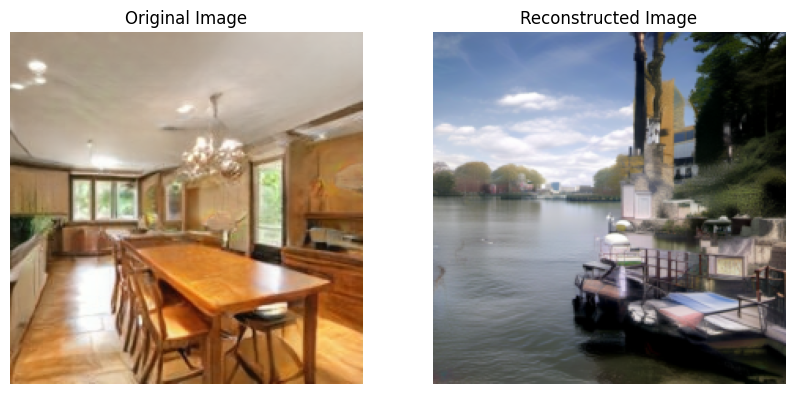

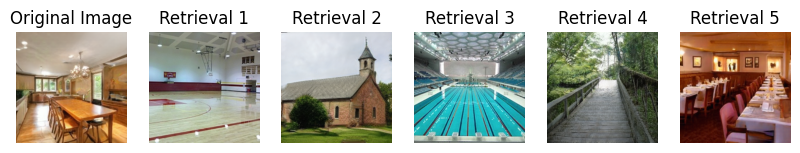

TR 37
blank
TR 38
blank
TR 39
all_stimuli/unchosen_nsd_1000_images/unchosen_7707_cocoid_28432.png
TR 40
blank
TR 41
blank
TR 42
all_stimuli/unchosen_nsd_1000_images/unchosen_3335_cocoid_42819.png
TR 43
blank
TR 44
all_stimuli/unchosen_nsd_1000_images/unchosen_2358_cocoid_39186.png
TR 45
blank
TR 46
blank
TR 47
all_stimuli/unchosen_nsd_1000_images/unchosen_2249_cocoid_6116.png
TR 48
blank
TR 49
blank
TR 50
all_stimuli/unchosen_nsd_1000_images/unchosen_7892_cocoid_61880.png
TR 51
blank
TR 52
all_stimuli/unchosen_nsd_1000_images/unchosen_8601_cocoid_64851.png
TR 53
blank
TR 54
blank
TR 55
all_stimuli/unchosen_nsd_1000_images/unchosen_6257_cocoid_55334.png
TR 56
blank
TR 57
blank
TR 58
all_stimuli/shared1000_notspecial/notspecial_4325.png
TR 59
blank
TR 60
blank.jpg
TR 61
blank
TR 62
blank
TR 63
all_stimuli/unchosen_nsd_1000_images/unchosen_6825_cocoid_57631.png
TR 64
blank
TR 65
blank
TR 66
all_stimuli/unchosen_nsd_1000_images/unchosen_3173_cocoid_42022.png
TR 67
blank
TR 68
all_stimuli/s

sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Given Brain embedding, find correct Image embedding


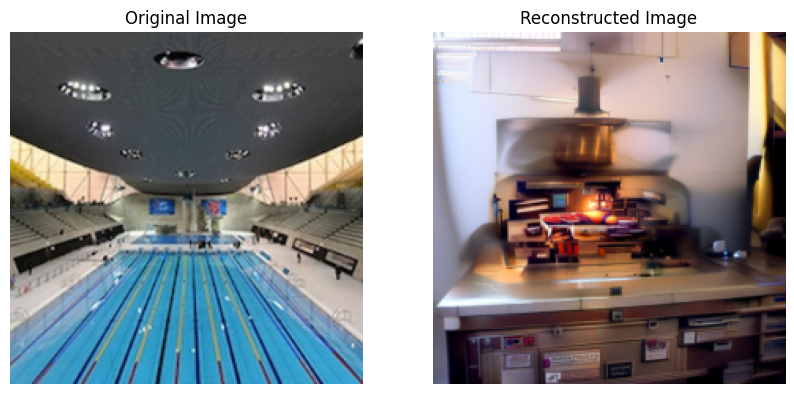

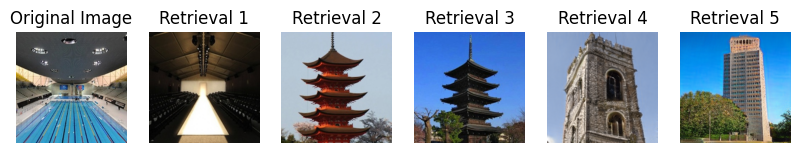

TR 80
blank
TR 81
blank
TR 82
all_stimuli/MST_pairs/pair_37_w_airplane_interior2.jpg


sampling loop time step:   0%|          | 0/19 [00:00<?, ?it/s]

/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Given Brain embedding, find correct Image embedding


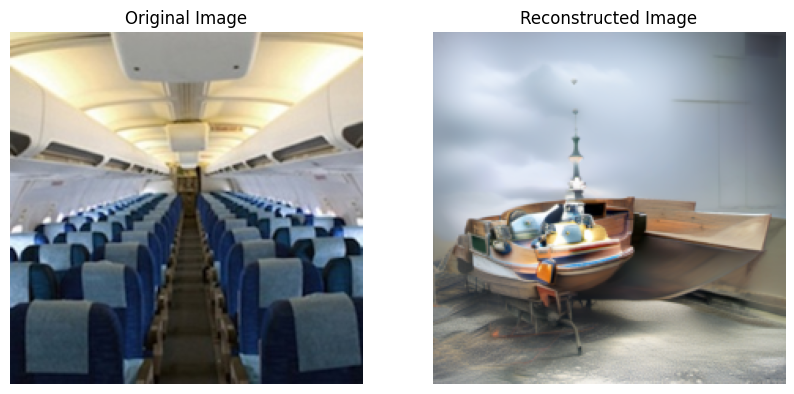

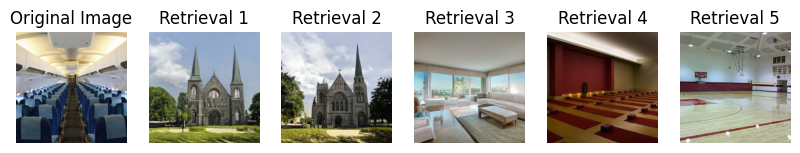

TR 83
blank
TR 84
all_stimuli/unchosen_nsd_1000_images/unchosen_6328_cocoid_22875.png
TR 85
blank
TR 86
blank
TR 87
blank.jpg
TR 88
blank
TR 89
blank
TR 90
all_stimuli/unchosen_nsd_1000_images/unchosen_5263_cocoid_51166.png


FileNotFoundError: /scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/3t/derivatives/motion_corrected/sub-005_ses-03_task-C_run-01_bold_0090_mc.par not found.

In [20]:
mc_dir = f"{derivatives_path}/motion_corrected"
mc_resampled_dir = f"{derivatives_path}/motion_corrected_resampled"
if os.path.exists(mc_dir):
    shutil.rmtree(mc_dir)
os.makedirs(mc_dir)
if os.path.exists(mc_resampled_dir):
    shutil.rmtree(mc_resampled_dir)
os.makedirs(mc_resampled_dir)

ses3_to_ses1_mat = f'{derivatives_path}/ses3ref_to_ses1ref'
# set the output type to NIFTI_GZ
os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
assert np.all(fmriprep_boldref_nib.affine == union_mask_img.affine)
all_betas = []

# Loop over all 11 runs in the session
n_runs = 11
for run_num in range(1, n_runs + 1):
    print(f"Run {run_num} started")
    mc_params = []
    imgs = []
    events_df = ndscore_events[run_num - 1]
    tr_labels_hrf = ndscore_tr_labels[run_num - 1]["tr_label_hrf"].tolist()
    events_df = events_df[events_df['image_name'] != 'blank.jpg']  # must drop blank.jpg after tr_labels_hrf is defined to keep indexing consistent
    beta_maps_list = []
    all_trial_names_list = []
    all_images = None

    # define save_path
    save_path = f"{derivatives_path}/{sub}_{session}_task-{func_task_name}_run-{run_num:02d}_recons"
    os.makedirs(save_path, exist_ok=True)
    save_individual_images = True
    if save_individual_images:
        os.makedirs(os.path.join(save_path, "individual_images"), exist_ok=True)

    all_recons_save = []
    all_clipvoxels_save = []
    all_ground_truth_save = []
    all_retrieved_save = []

    stimulus_trial_counter = 0
    plot_images = True
    T1_brain = f"{data_path}/sub-005_desc-preproc_T1w_brain.nii.gz"
    n_trs = 192
    assert len(tr_labels_hrf) == n_trs, "there should be image labels for each TR"
    assert all(label in image_names for label in tr_labels_hrf if label != 'blank'), "Some labels in tr_labels_hrf are missing from image_names."
    assert len(images) > n_trs, "images array is too short."
    for TR in range(n_trs-1):
        print(f"TR {TR}")
        # stream in the nifti
        cur_vol = f"{sub}_{session}_task-{func_task_name}_run-{run_num:02d}_bold_{TR:04d}"
        curr_image_path = os.path.join(single_vols_path, f"{cur_vol}.nii.gz")
        image_data = nib.load(curr_image_path)
        current_label = tr_labels_hrf[TR]
        print(current_label)
        if TR == 0 and run_num == 1:
            # ses3_vol0_nib = image_data
            # make the day 2 bold ref
            nib.save(image_data, rt_vol0)
            # save the transformation from the day 2 bold ref to the day 1 
            # os.system(f"antsRegistrationSyNQuick.sh \
            #   -d 3 \
            #   -f {T1_brain} \
            #   -m {rt_vol0} \
            #   -o {derivatives_path}/ses3_vol0_epi2T1_")

            os.system(f"flirt -in {rt_vol0} \
                -ref {fmriprep_boldref} \
                -omat {ses3_to_ses1_mat} \
                -dof 6")

            # for simulation, just load it in
            # ses3_boldref_path = f"{derivatives_path}/ses3_vol0_epi2T1_Warped.nii.gz"
            # ses3_boldref = nib.load(ses3_boldref_path)
        # load nifti file
        # tmp = f'{storage_path}/day2_subj1/tmp_run{run_num}.nii.gz'
        # nib.save(index_img(image_data,0),tmp)
        start = time.time()
        mc = f"{mc_dir}/{cur_vol}_mc"
        os.system(f"{fsl_path}/mcflirt -in {os.path.join(single_vols_path, f'{cur_vol}.nii.gz')} -reffile {os.path.join(single_vols_path, f'{sub}_{session}_task-{func_task_name}_run-01_bold_0000.nii.gz')} -out {mc} -plots -mats")
        mc_params.append(np.loadtxt(f'{mc}.par'))

        current_tr_to_ses1 = f"{derivatives_path}/current_tr_to_ses1_run{run_num}"
        os.system(f"convert_xfm -concat {ses3_to_ses1_mat} -omat {current_tr_to_ses1} {mc}.mat/MAT_0000")    
        
        # apply concatenated matrix to the current TR
        final_vol = f"{mc_resampled_dir}/{session}_run-{run_num:02d}_{TR:04d}_mc_boldres.nii.gz"
        os.system(f"flirt -in {curr_image_path} \
            -ref {fmriprep_boldref} \
            -out {final_vol} \
            -init {current_tr_to_ses1} \
            -applyxfm")

        os.system(f"rm -r {mc}.mat")
        imgs.append(get_data(final_vol))
        
        if current_label not in ('blank', 'blank.jpg'):
            events_df = events_df.copy()
            events_df['onset'] = events_df['onset'].astype(float)

            run_start_time = events_df['onset'].iloc[0]
            events_df = events_df.copy()
            events_df['onset'] -= run_start_time

            cropped_events = events_df[events_df.onset <= TR*tr_length]
            cropped_events = cropped_events.copy()
            cropped_events.loc[:, 'trial_type'] = np.where(cropped_events['trial_number'] == stimulus_trial_counter, "probe", "reference")
            cropped_events = cropped_events.drop(columns=['is_correct', 'image_name', 'response_time', 'trial_number'])

            # collect all of the images at each TR into a 4D time series
            img = np.rollaxis(np.array(imgs),0,4)
            img = new_img_like(fmriprep_boldref_nib,img,copy_header=True)
            # run the model with mc_params confounds to motion correct
            lss_glm = FirstLevelModel(t_r=tr_length,slice_time_ref=0,hrf_model='glover',
                        drift_model='cosine', drift_order=1,high_pass=0.01,mask_img=union_mask_img,
                        signal_scaling=False,smoothing_fwhm=None,noise_model='ar1',
                        n_jobs=-1,verbose=-1,memory_level=1,minimize_memory=True)

            lss_glm.fit(run_imgs=img, events=cropped_events, confounds = pd.DataFrame(np.array(mc_params)))
            dm = lss_glm.design_matrices_[0]
            # get the beta map and mask it
            beta_map = lss_glm.compute_contrast("probe", output_type="effect_size")
            beta_map_np = beta_map.get_fdata()
            beta_map_np = fast_apply_mask(target=beta_map_np,mask=union_mask_img.get_fdata())
            all_betas.append(beta_map_np)
            
            if only_betas:
                continue
            if "MST_pairs" in current_label:
                correct_image_index = np.where(current_label == vox_image_names)[0][0]  # using the first occurrence based on image name, assumes that repeated images are identical (which they should be)
                z_mean = np.mean(np.array(all_betas), axis=0)
                z_std = np.std(np.array(all_betas), axis=0)
                betas = ((np.array(all_betas) - z_mean) / (z_std + 1e-6))[-1]  # use only the beta pattern from the most recent image
                betas = betas[np.newaxis, np.newaxis, :]
                betas_tt = torch.Tensor(betas).to("cpu")
                reconsTR, clipvoxelsTR = do_reconstructions(betas_tt)
                if clipvoxelsTR is None:
                    with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
                        voxel = betas_tt
                        voxel = voxel.to(device)
                        assert voxel.shape[1] == 1
                        voxel_ridge = model.ridge(voxel[:,[-1]],0) # 0th index of subj_list
                        backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
                        clip_voxels = clip_voxels0
                        backbone = backbone0
                        blurry_image_enc = blurry_image_enc0[0]
                        clipvoxelsTR = clip_voxels.cpu()
                values_dict = get_top_retrievals(clipvoxelsTR, all_images=images[MST_idx], total_retrievals=5)
                image_array = np.array(reconsTR)[0]
                # If the image has 3 channels (RGB), you need to reorder the dimensions
                if image_array.ndim == 3 and image_array.shape[0] == 3:
                    image_array = np.transpose(image_array, (1, 2, 0))  # Change shape to (height, width, 3)

                # Display the image
                if plot_images:
                    # plot original and reconstructed images
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 2, 1)
                    plt.title("Original Image")
                    plt.imshow(images[correct_image_index].numpy().transpose(1, 2, 0), cmap='gray')
                    plt.axis('off')
                    plt.subplot(1, 2, 2)
                    plt.title("Reconstructed Image")
                    plt.imshow(image_array, cmap='gray' if image_array.ndim == 2 else None)
                    plt.axis('off')
                    plt.show()

                    # plot original with top 5 retrievals
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 6, 1)
                    plt.title("Original Image")
                    plt.imshow(images[correct_image_index].numpy().transpose(1, 2, 0), cmap='gray')
                    plt.axis('off')
                    for i in range(5):
                        plt.subplot(1, 6, i+2)
                        plt.title(f"Retrieval {i+1}")
                        plt.imshow(np.array(values_dict[f"attempt{i+1}"][0]).transpose(1, 2, 0), cmap='gray')
                        plt.axis('off')
                    plt.show()

                # save reconstructed image, retrieved images, clip_voxels, and ground truth image
                if save_individual_images:
                    # save the reconstructed image
                    convert_image_array_to_PIL(image_array).save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_reconstructed.png"))
                    # save the retrieved images
                    for key, value in values_dict.items():
                        if (not ('ground_truth' in key)):
                            convert_image_array_to_PIL(np.array(value)).save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_retrieved_{key}.png"))
                    # save the clip_voxels
                    np.save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_clip_voxels.npy"), clipvoxelsTR)
                    # save the ground truth image
                    convert_image_array_to_PIL(images[correct_image_index].numpy()).save(os.path.join(save_path, "individual_images", f"run{run_num}_TR{TR}_ground_truth.png"))
                all_recons_save.append(image_array)
                all_clipvoxels_save.append(clipvoxelsTR)
                all_ground_truth_save.append(images[correct_image_index].numpy())
                all_retrieved_save.append([np.array(value) for key, value in values_dict.items() if (not ('ground_truth' in key))])
            else:
                pass
            stimulus_trial_counter += 1
        elif current_label == 'blank.jpg':
            stimulus_trial_counter += 1
        else:
            assert current_label == 'blank'

    # save betas so far
    np.save(os.path.join(save_path, f"betas_run-{run_num:02d}.npy"), np.array(all_betas))
    if only_betas:
        continue
    # save the design matrix for the current run
    dm.to_csv(os.path.join(save_path, f"design_run-{run_num:02d}.csv"))
    plot_design_matrix(dm, output_file=os.path.join(save_path, "dm"))
    dm[['probe', 'reference']].plot(title='Probe/Reference Regressors', figsize=(10, 4))
    # dm[['probe_hrf_callable', 'reference_hrf_callable']].plot(title='Probe/Reference Regressors', figsize=(10, 4))
    plt.savefig(os.path.join(save_path, "regressors"))
    print(f"==END OF RUN {run_num}!==\n")
    # save the tensors
    if all_recons_save:
        all_recons_save_tensor = torch.tensor(all_recons_save).permute(0,3,1,2)
        all_clipvoxels_save_tensor = torch.stack(all_clipvoxels_save, dim=0)
        all_ground_truth_save_tensor = torch.tensor(all_ground_truth_save)
        all_retrieved_save_tensor = torch.stack([torch.tensor(np.array(item)) for item in all_retrieved_save], dim=0)
        torch.save(all_recons_save_tensor, os.path.join(save_path, "all_recons.pt"))
        torch.save(all_clipvoxels_save_tensor, os.path.join(save_path, "all_clipvoxels.pt"))
        torch.save(all_ground_truth_save_tensor, os.path.join(save_path, "all_ground_truth.pt"))
        torch.save(all_retrieved_save_tensor, os.path.join(save_path, "all_retrieved.pt"))
        print("all_recons_save_tensor.shape: ", all_recons_save_tensor.shape)
        print("all_clipvoxels_save_tensor.shape: ", all_clipvoxels_save_tensor.shape)
        print("all_ground_truth_save_tensor.shape: ", all_ground_truth_save_tensor.shape)
        print("all_retrieved_save_tensor.shape: ", all_retrieved_save_tensor.shape)
        print("All tensors saved successfully on ", save_path)

In [ ]:
# # load and display all recons with originals
# all_recons_save = torch.load(os.path.join(save_path, "all_recons.pt"))
# for i in range(len(all_recons_save)):
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.title("Original Image")
#     plt.imshow(all_ground_truth_save[i].numpy().transpose(1, 2, 0), cmap='gray')
#     plt.axis('off')  # Hide axes
#     plt.subplot(1, 2, 2)
#     plt.title("Reconstructed Image")
#     plt.imshow(all_recons_save[i].numpy().transpose(1, 2, 0), cmap='gray')
#     plt.axis('off')  # Hide axes

#     plt.show()


In [ ]:
# # load and display top 5 retrievals and originals
# for i in range(len(all_retrieved_save)):
#     plt.figure(figsize=(15, 10))
#     plt.subplot(1, 6, 1)
#     plt.title("Original")
#     plt.imshow(all_ground_truth_save[i].numpy().transpose(1, 2, 0), cmap='gray')
#     plt.axis('off')  # Hide axes
#     for j in range(5):
#         plt.subplot(1, 6, j+2)
#         plt.title(f"Top {j+1}")
#         plt.imshow(all_retrieved_save[i][j][0].numpy().transpose(1, 2, 0), cmap='gray')
#         plt.axis('off')  # Hide axes
#     plt.show()

In [ ]:
# def run_recons_and_evaluate(
#     beta_series,  # shape: (n_conditions, n_voxels)
#     images,       # tensor of all images, shape: (n_images, 3, 224, 224)
#     model,        # loaded model
#     do_reconstructions,  # function for recon
#     device,       # torch device
#     save_path=None,    # directory to save results
#     metrics_module=None,  # module or dict with metric functions, optional
#     save_results=False,   # flag to control saving, defaults to False
#     test_idx=None,         # indices for test set, optional
#     do_zscore=False
# ):
#     if test_idx is not None:
#         beta_series = beta_series[test_idx]
#         images = images[test_idx]

#     all_recons_save_tensor = []
#     all_clipvoxels_save_tensor = []
#     all_ground_truth_save_tensor = []

#     for idx in range(beta_series.shape[0]):
#         beta_pattern = beta_series[np.newaxis, np.newaxis, idx, :]  # (1,1,n_vox)
#         if do_zscore:
#             # Z-score using only betas up to and including the current image
#             beta_series_up_to_now = beta_series[:idx+1]
#             beta_pattern = utils_mindeye.zscore(beta_pattern, beta_series_up_to_now)

#         betas_tt = torch.Tensor(beta_pattern).to("cpu")
#         reconsTR, clipvoxelsTR = do_reconstructions(betas_tt)
#         if clipvoxelsTR is None:
#             with torch.no_grad(), torch.cuda.amp.autocast(dtype=torch.float16):
#                 voxel = betas_tt.to(device)
#                 assert voxel.shape[1] == 1
#                 voxel_ridge = model.ridge(voxel[:, [-1]], 0)
#                 backbone0, clip_voxels0, blurry_image_enc0 = model.backbone(voxel_ridge)
#                 clipvoxelsTR = clip_voxels0.cpu()

#         image_array = np.array(reconsTR)[0]
#         if image_array.ndim == 3 and image_array.shape[0] == 3:
#             image_array = np.transpose(image_array, (1, 2, 0))

#         all_recons_save_tensor.append(reconsTR)
#         all_clipvoxels_save_tensor.append(clipvoxelsTR)
#         all_ground_truth_save_tensor.append(images[idx])

#     all_recons_save_tensor = torch.stack(all_recons_save_tensor)
#     all_clipvoxels_save_tensor = torch.stack(all_clipvoxels_save_tensor)
#     all_ground_truth_save_tensor = torch.stack(all_ground_truth_save_tensor)

#     if save_results and save_path is not None:
#         os.makedirs(save_path, exist_ok=True)
#         torch.save(all_recons_save_tensor, os.path.join(save_path, "all_recons.pt"))
#         torch.save(all_clipvoxels_save_tensor, os.path.join(save_path, "all_clipvoxels.pt"))
#         torch.save(all_ground_truth_save_tensor, os.path.join(save_path, "all_ground_truth.pt"))

#     if metrics_module is not None:
#         with torch.autocast(device_type="cuda", dtype=torch.float16):
#             unique_clip_voxels = all_clipvoxels_save_tensor
#             unique_ground_truth = all_ground_truth_save_tensor
#             all_fwd_acc, all_bwd_acc = metrics_module['calculate_retrieval_metrics'](unique_clip_voxels, unique_ground_truth)
#             pixcorr = metrics_module['calculate_pixcorr'](all_recons_save_tensor, all_ground_truth_save_tensor)
#             ssim_ = metrics_module['calculate_ssim'](all_recons_save_tensor, all_ground_truth_save_tensor)
#             alexnet2, alexnet5 = metrics_module['calculate_alexnet'](all_recons_save_tensor, all_ground_truth_save_tensor)
#             inception = metrics_module['calculate_inception_v3'](all_recons_save_tensor, all_ground_truth_save_tensor)
#             clip_ = metrics_module['calculate_clip'](all_recons_save_tensor, all_ground_truth_save_tensor)
#             efficientnet = metrics_module['calculate_efficientnet_b1'](all_recons_save_tensor, all_ground_truth_save_tensor)
#             swav = metrics_module['calculate_swav'](all_recons_save_tensor, all_ground_truth_save_tensor)

#         df_metrics = pd.DataFrame({
#             "Metric": [
#                 "alexnet2",
#                 "alexnet5",
#                 "inception",
#                 "clip_",
#                 "efficientnet",
#                 "swav",
#                 "pixcorr",
#                 "ssim",
#                 "all_fwd_acc",
#                 "all_bwd_acc"
#             ],
#             "Value": [
#                 alexnet2,
#                 alexnet5,
#                 inception,
#                 clip_,
#                 efficientnet,
#                 swav,
#                 pixcorr,
#                 ssim_,
#                 all_fwd_acc,
#                 all_bwd_acc
#             ]
#         })
#         df_metrics.set_index("Metric", inplace=True)
#         if save_results and save_path is not None:
#             df_metrics.to_csv(os.path.join(save_path, "metrics.csv"))
#         print(df_metrics)

#     return all_recons_save_tensor, all_clipvoxels_save_tensor, all_ground_truth_save_tensor

In [21]:
# Run evaluation metrics
from utils_mindeye import calculate_retrieval_metrics, calculate_alexnet, calculate_clip, calculate_swav, calculate_efficientnet_b1, calculate_inception_v3, calculate_pixcorr, calculate_ssim, deduplicate_tensors
all_recons_save_tensor = []
all_clipvoxels_save_tensor = []
all_ground_truth_save_tensor = []
all_retrieved_save_tensor = []

for run_num in range(n_runs):
    save_path = f"{derivatives_path}/{sub}_{session}_task-{func_task_name}_run-{run_num+1:02d}_recons"

    try:
        # recons = torch.load(os.path.join(save_path, "all_recons.pt")).to(torch.float16)
        # clipvoxels = torch.load(os.path.join(save_path, "all_clipvoxels.pt")).to(torch.float16)
        # ground_truth = torch.load(os.path.join(save_path, "all_ground_truth.pt")).to(torch.float16)
        recons = torch.load(os.path.join(save_path, "all_recons.pt")).to(torch.float16).to(device)
        clipvoxels = torch.load(os.path.join(save_path, "all_clipvoxels.pt")).to(torch.float16).to(device)
        ground_truth = torch.load(os.path.join(save_path, "all_ground_truth.pt")).to(torch.float16).to(device)

        all_recons_save_tensor.append(recons)
        all_clipvoxels_save_tensor.append(clipvoxels)
        all_ground_truth_save_tensor.append(ground_truth)
    except FileNotFoundError:
        print("Error: Tensors not found. Please check the save path.")

# Concatenate tensors along the first dimension
try:
    all_recons_save_tensor = torch.cat(all_recons_save_tensor, dim=0)
    all_clipvoxels_save_tensor = torch.cat(all_clipvoxels_save_tensor, dim=0)
    all_ground_truth_save_tensor = torch.cat(all_ground_truth_save_tensor, dim=0)
except RuntimeError:
    print('Error: Couldn\'t concatenate tensors')

with torch.autocast(device_type="cuda", dtype=torch.float16):
    unique_clip_voxels, unique_ground_truth, duplicated = deduplicate_tensors(all_clipvoxels_save_tensor, all_ground_truth_save_tensor)
    
    print('calculating retrieval subset 0 (first set of repeats)')
    unique_clip_voxels_subset0 = all_clipvoxels_save_tensor[np.array(duplicated)[:,0]]
    unique_ground_truth_subset0 = all_ground_truth_save_tensor[np.array(duplicated)[:,0]]
    all_fwd_acc_subset0, all_bwd_acc_subset0 = calculate_retrieval_metrics(unique_clip_voxels_subset0, unique_ground_truth_subset0)

    print('calculating retrieval subset 1 (second set of repeats)')
    unique_clip_voxels_subset1 = all_clipvoxels_save_tensor[np.array(duplicated)[:,1]]
    unique_ground_truth_subset1 = all_ground_truth_save_tensor[np.array(duplicated)[:,1]]
    all_fwd_acc_subset1, all_bwd_acc_subset1 = calculate_retrieval_metrics(unique_clip_voxels_subset1, unique_ground_truth_subset1)
    pixcorr = calculate_pixcorr(all_recons_save_tensor, all_ground_truth_save_tensor)
    ssim_ = calculate_ssim(all_recons_save_tensor, all_ground_truth_save_tensor)
    alexnet2, alexnet5 = calculate_alexnet(all_recons_save_tensor, all_ground_truth_save_tensor)
    inception = calculate_inception_v3(all_recons_save_tensor, all_ground_truth_save_tensor)
    clip_ = calculate_clip(all_recons_save_tensor, all_ground_truth_save_tensor)
    efficientnet = calculate_efficientnet_b1(all_recons_save_tensor, all_ground_truth_save_tensor)
    swav = calculate_swav(all_recons_save_tensor, all_ground_truth_save_tensor)


# save the results to a csv file
df_metrics = pd.DataFrame({
    "Metric": [
        "alexnet2",
        "alexnet5",
        "inception",
        "clip_",
        "efficientnet",
        "swav",
        "pixcorr",
        "ssim",
        "all_fwd_acc_subset0",
        "all_bwd_acc_subset0",
        "all_fwd_acc_subset1",
        "all_bwd_acc_subset1"
    ],
    "Value": [
        alexnet2,
        alexnet5,
        inception,
        clip_,
        efficientnet,
        swav,
        pixcorr,
        ssim_,
        all_fwd_acc_subset0,
        all_bwd_acc_subset0,
        all_fwd_acc_subset1,
        all_bwd_acc_subset1
    ]
})

calculating retrieval subset 0 (first set of repeats)
Loading clip_img_embedder
The total pool of images and clip voxels to do retrieval on is:  62
Creating embeddings for images
Calculating retrieval metrics
overall fwd percent_correct: 0.2903
overall bwd percent_correct: 0.2419
calculating retrieval subset 1 (second set of repeats)
Loading clip_img_embedder
The total pool of images and clip voxels to do retrieval on is:  62
Creating embeddings for images
Calculating retrieval metrics


/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


overall fwd percent_correct: 0.2742
overall bwd percent_correct: 0.3710
torch.Size([124, 541875])
torch.Size([124, 541875])


100%|████████████████████████████████████████| 124/124 [00:00<00:00, 209.40it/s]


Pixel Correlation: 0.07574728082449247
converted, now calculating ssim...


100%|█████████████████████████████████████████| 124/124 [00:01<00:00, 84.50it/s]


SSIM: 0.32581088802420394
Loading AlexNet


/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,



---early, AlexNet(2)---
2-way Percent Correct (early AlexNet): 0.6386

---mid, AlexNet(5)---
2-way Percent Correct (mid AlexNet): 0.6500
Loading Inception V3


/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torchvision/models/feature_extraction.py:174: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


2-way Percent Correct (Inception V3): 0.5532
Loading CLIP
2-way Percent Correct (CLIP): 0.5286
Loading EfficientNet B1
Distance EfficientNet B1: 0.927114466525869
Loading SwAV


Using cache found in /home/ri4541/.cache/torch/hub/facebookresearch_swav_main
/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/gpfs/ri4541/tmp/rtcloud-projects/mindeye/config/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Distance SwAV: 0.5981813939936649


In [22]:
percentage_metrics = ["alexnet2", "alexnet5", "inception", "clip_", "all_fwd_acc_subset0", "all_bwd_acc_subset0", "all_bwd_acc_subset1", "all_fwd_acc_subset1"]
lower_better_metrics = ["efficientnet", "swav"]
higher_better_arrow = "↑"
lower_better_arrow = "↓"

# Format function
def format_metric(metric, value):
    if metric in percentage_metrics:
        return f"{value * 100:.2f}% {higher_better_arrow}"
    elif metric in lower_better_metrics:
        return f"{value:.2f} {lower_better_arrow}"
    else:
        return f"{value:.2f} {higher_better_arrow}"

# Apply formatting
df_formatted = df_metrics.copy()
df_formatted["Formatted"] = df_formatted.apply(lambda row: format_metric(row["Metric"], row["Value"]), axis=1)
df_formatted.set_index("Metric", inplace=True)
df_formatted.index.name = "Metric"

# Print and save
display(df_formatted[["Formatted"]])

df_formatted[["Formatted"]].to_csv(os.path.join(save_path, "metrics.csv"))

,Formatted
Metric,
alexnet2,63.86% ↑
alexnet5,65.00% ↑
inception,55.32% ↑
clip_,52.86% ↑
efficientnet,0.93 ↓
swav,0.60 ↓
pixcorr,0.08 ↑
ssim,0.33 ↑
all_fwd_acc_subset0,29.03% ↑


In [23]:
df_formatted = df_metrics.copy()
df_formatted["Formatted"] = df_formatted.apply(lambda row: format_metric(row["Metric"], row["Value"]), axis=1)

# Print and save
# display(df_formatted[["Formatted"]])
display(df_formatted[['Metric', 'Formatted']])

,Metric,Formatted
0,alexnet2,63.86% ↑
1,alexnet5,65.00% ↑
2,inception,55.32% ↑
3,clip_,52.86% ↑
4,efficientnet,0.93 ↓
5,swav,0.60 ↓
6,pixcorr,0.08 ↑
7,ssim,0.33 ↑
8,all_fwd_acc_subset0,29.03% ↑
9,all_bwd_acc_subset0,24.19% ↑


In [24]:
df_formatted.columns

Index(['Metric', 'Value', 'Formatted'], dtype='object')